# Big Data in Little Laptop with Toolz

> GRACIE: A knife? The guy's twelve feet tall!<br/>
> JACK: Seven. Hey, don't worry, I think I can handle him.
>
> — Jack Burton, *Big Trouble in Little China*

Streaming is not a SciPy feature per se, but rather an approach that
allows us to efficiently process large datasets, like those often
seen in science. The Python language contains some useful primitives
for streaming data processing, and these can be combined with Matt Rocklin's
Toolz library to generate elegant, concise code that is extremely
memory-efficient. In this chapter, we will show you how to apply these
streaming concepts to enable you to handle much larger datasets than can fit
in your computer's RAM.

You have probably already done some streaming, perhaps without thinking about it in these terms.
The simplest form is probably iterating through lines in a files, processing each line without ever reading the entire file into memory.
For example a loop like this to calculate the mean of each row and sum them:

In [1]:
import numpy as np
with open('data/expr.tsv') as f:
    sum_of_means = 0
    for line in f:
        sum_of_means += np.mean(np.fromstring(line, dtype=int, sep='\t'))
print(sum_of_means)

1463.0


This strategy works really well for cases where your problem can be neatly solved with by-row processing.
But things can quickly get out of hand when your code becomes more sophisticated.

In streaming programs, a function processes *some* of the input data, returns the
processed chunk, then, while downstream functions are dealing with that chunk,
the function receives a bit more, and so on...  All these things are going on
at the same time!  How can one keep them straight?

We too found this difficult, until we discovered the `toolz` library.
Its constructs make streaming programs so elegant to write that
it was impossible to contemplate writing this book without including a chapter
about it.

Let us clarify what we mean by "streaming" and why you might want to do it.
Suppose you have some data in a text file, and you want to compute the column-wise average of $\log(x+1)$ of the values.
The common way to do this would be to use NumPy to load the values, compute the log function for all values in the full matrix, and then take the mean over the 1st axis:

In [2]:
import numpy as np
expr = np.loadtxt('data/expr.tsv')
logexpr = np.log(expr + 1)
np.mean(logexpr, axis=0)

array([3.11797294, 2.48682887, 2.19580049, 2.36001866, 2.70124539,
       2.64721531, 2.43704834, 3.28539133, 2.05363724, 2.37151577,
       3.85450782, 3.9488385 , 2.46680157, 2.36334423, 3.18381635,
       2.64438124, 2.62966516, 2.84790568, 2.61691451, 4.12513405])

This works, and it follows a reassuringly familiar input-output model of computation.
But it's a pretty inefficient way to go about it!
We load the full matrix into memory (1), then make a copy with 1 added to each value (2), then make another copy to compute the log (3), before finally passing it on to `np.mean`.
That's three instances of the data array, to perform an operation that doesn't require keeping even *one* instance in memory.
For any kind of "big data" operation, this approach won't work.

Python's creators knew this, and created the "yield" keyword, which enables a function to process just one "sip" of the data, pass the result on to the next process, and *let the chain of processing complete* for that one piece of data before moving on to the next one.
"Yield" is a rather nice name for it: the function *yields* control to the next function, waiting to resume processing the data until all the downstream steps have processed that data point.

## Streaming with `yield`

The flow of control described above can be rather hard to follow.
An awesome feature of Python is that it abstracts this complexity away, allowing you to focus on the analysis functionality.
Here's one way to think about it: for every processing function that would normally take a list (a collection of data) and transform that list, you can rewrite that function as taking a *stream* and *yielding* the result of every element of that stream.

Here's an example where we take the log of each element in a list, using either a standard data-copying method or a streaming method:

In [3]:
def log_all_standard(input):
    output = []
    for elem in input:
        output.append(np.log(elem))
    return output

def log_all_streaming(input_stream):
    for elem in input_stream:
        yield np.log(elem)

Let's check that we get the same result with both methods:

In [4]:
# We set the random seed so we will get consistent results
np.random.seed(seed=7)
# Set print options to show only 3 significant digits
np.set_printoptions(precision=3, suppress=True)

arr = np.random.rand(1000) + 0.5
result_batch = sum(log_all_standard(arr))
print('Batch result: ', result_batch)
result_stream = sum(log_all_streaming(arr))
print('Stream result: ', result_stream)

Batch result:  -48.2409194560661
Stream result:  -48.2409194560661


The advantage of the streaming approach is that elements of a stream aren't processed until they're needed, whether it's for computing a running sum, or for writing out to disk, or something else.
This can conserve a lot of memory when you have many input items, or when each item is very big.
(Or both!)
This quote from one of Matt's blog posts very succinctly summarizes the utility of streaming data analysis:

> In my brief experience people rarely take this [streaming] route.
They use single-threaded in-memory Python until it breaks, and then seek out Big Data Infrastructure like Hadoop/Spark at relatively high productivity overhead.

Indeed, this describes our computational careers perfectly.
But the intermediate approach can get you a *lot* farther than you think.
In some cases, it can get you there even faster than the supercomputing approach, by eliminating the overhead of multi-core communication and random-access to databases.
(For example, see [this post](http://www.frankmcsherry.org/graph/scalability/cost/2015/02/04/COST2.html) by Frank McSherry, where he processes a 128 billion edge graph on his laptop *faster* than using a graph database on a supercomputer.)

To clarify the flow of control when using streaming-style functions, it's useful to make *verbose* versions of the functions, which print out a message with each operation.

In [5]:
import numpy as np

def tsv_line_to_array(line):
    lst = [float(elem) for elem in line.rstrip().split('\t')]
    return np.array(lst)

def readtsv(filename):
    print('starting readtsv')
    with open(filename) as fin:
        for i, line in enumerate(fin):
            print(f'reading line {i}')
            yield tsv_line_to_array(line)
    print('finished readtsv')

def add1(arrays_iter):
    print('starting adding 1')
    for i, arr in enumerate(arrays_iter):
        print(f'adding 1 to line {i}')
        yield arr + 1
    print('finished adding 1')

def log(arrays_iter):
    print('starting log')
    for i, arr in enumerate(arrays_iter):
        print(f'taking log of array {i}')
        yield np.log(arr)
    print('finished log')

def running_mean(arrays_iter):
    print('starting running mean')
    for i, arr in enumerate(arrays_iter):
        if i == 0:
            mean = arr
        mean += (arr - mean) / (i + 1)
        print(f'adding line {i} to the running mean')
    print('returning mean')
    return mean

Let's see it in action for a small sample file:

In [6]:
fin = 'data/expr.tsv'
print('Creating lines iterator')
lines = readtsv(fin)
print('Creating loglines iterator')
loglines = log(add1(lines))
print('Computing mean')
mean = running_mean(loglines)
print(f'the mean log-row is: {mean}')

Creating lines iterator
Creating loglines iterator
Computing mean
starting running mean
starting log
starting adding 1
starting readtsv
reading line 0
adding 1 to line 0
taking log of array 0
adding line 0 to the running mean
reading line 1
adding 1 to line 1
taking log of array 1
adding line 1 to the running mean
reading line 2
adding 1 to line 2
taking log of array 2
adding line 2 to the running mean
reading line 3
adding 1 to line 3
taking log of array 3
adding line 3 to the running mean
reading line 4
adding 1 to line 4
taking log of array 4
adding line 4 to the running mean
finished readtsv
finished adding 1
finished log
returning mean
the mean log-row is: [3.118 2.487 2.196 2.36  2.701 2.647 2.437 3.285 2.054 2.372 3.855 3.949
 2.467 2.363 3.184 2.644 2.63  2.848 2.617 4.125]


Note:

- None of the computation is run when creating the lines and loglines iterators. This is because iterators are *lazy*, meaning they are not evaluated (or *consumed*) until a result is needed.
- When the computation is finally triggered, by the call to `running_mean`, it jumps back and forth between all the functions, as various computations are performed on each line, before moving on to the next line.

## Introducing the Toolz streaming library

In this chapter's code example, contributed by Matt Rocklin, we create a Markov model from an entire fly genome in under 5 minutes on a laptop, using just a few lines of code.
(We have slightly edited it for easier downstream processing.)
Matt's example uses a human genome, but apparently our laptops weren't quite so fast, so we're going to use a fly genome instead (it's about 1/20 the size).
Over the course of the chapter we'll actually augment it a little bit to start from compressed data (who wants to keep an uncompressed dataset on their hard drive?).
This modification is almost *trivial*, which speaks to the elegance of his example.

In [7]:
import toolz as tz
from toolz import curried as c
from glob import glob
import itertools as it

LDICT = dict(zip('ACGTacgt', range(8)))
PDICT = {(a, b): (LDICT[a], LDICT[b])
         for a, b in it.product(LDICT, LDICT)}

def is_sequence(line):
    return not line.startswith('>')

def is_nucleotide(letter):
    return letter in LDICT  # ignore 'N'

@tz.curry
def increment_model(model, index):
    model[index] += 1


def genome(file_pattern):
    """Stream a genome, letter by letter, from a list of FASTA filenames."""
    return tz.pipe(file_pattern, glob, sorted,  # Filenames
                   c.map(open),  # lines
                   # concatenate lines from all files:
                   tz.concat,
                   # drop header from each sequence
                   c.filter(is_sequence),
                   # concatenate characters from all lines
                   tz.concat,
                   # discard newlines and 'N'
                   c.filter(is_nucleotide))


def markov(seq):
    """Get a 1st-order Markov model from a sequence of nucleotides."""
    model = np.zeros((8, 8))
    tz.last(tz.pipe(seq,
                    c.sliding_window(2),        # each successive tuple
                    c.map(PDICT.__getitem__),   # location in matrix of tuple
                    c.map(increment_model(model))))  # increment matrix
    # convert counts to transition probability matrix
    model /= np.sum(model, axis=1)[:, np.newaxis]
    return model

We can then do the following to obtain a Markov model of repetitive sequences
in the fruit-fly genome:

In [8]:
%%timeit -r 1 -n 1
dm = 'data/dm6.fa'
model = tz.pipe(dm, genome, c.take(10**7), markov)
# we use `take` to just run on the first 10 million bases, to speed things up.
# the take step can just be removed if you have ~5-10 mins to wait.

3.88 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/Users/squiresrb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


There's a *lot* going on in that example, so we are going to unpack it little by little.
We'll actually run the example at the end of the chapter.

The first thing to note is how many functions come from the [Toolz library](http://toolz.readthedocs.org/en/latest/).
For example from Toolz we've used, `pipe`, `sliding_window`, `frequencies`, and a curried version of `map` (more on this later).
That's because Toolz is written specifically to take advantage of Python's iterators, and easily manipulate streams.

Let's start with `pipe`.
This function is simply syntactic sugar to make nested function calls easier to read.
This is important because that pattern becomes increasingly common when dealing with iterators.

As a simple example, let's rewrite our running mean using `pipe`:

In [9]:
import toolz as tz
filename = 'data/expr.tsv'
mean = tz.pipe(filename, readtsv, add1, log, running_mean)

# This is equivalent to nesting the functions like this:
# running_mean(log(add1(readtsv(filename))))

starting running mean
starting log
starting adding 1
starting readtsv
reading line 0
adding 1 to line 0
taking log of array 0
adding line 0 to the running mean
reading line 1
adding 1 to line 1
taking log of array 1
adding line 1 to the running mean
reading line 2
adding 1 to line 2
taking log of array 2
adding line 2 to the running mean
reading line 3
adding 1 to line 3
taking log of array 3
adding line 3 to the running mean
reading line 4
adding 1 to line 4
taking log of array 4
adding line 4 to the running mean
finished readtsv
finished adding 1
finished log
returning mean


What was originally multiple lines, or an unwieldy mess of parentheses, is now a clean description of the sequential transformations of the input data.
Much easier to understand!

This strategy also has an advantage over the original NumPy implementation: if we scale our data to millions or billions of rows, our computer might struggle to hold all the data in memory.
In contrast, here we are only loading lines from disk one at a time, and maintaining only a single line's worth of data.

## k-mer counting and error correction

You might want to review chapters 1 and 2 for information about DNA and genomics.
Briefly, your genetic information, the blueprint for making *you*, is encoded as a sequence of chemical *bases* in your *genome*.
These are really, really tiny, so you can't just look in a microscope and read them.
You also can't read a long string of them: errors accumulate and the readout becomes unusable.
(New technology is changing this, but here we will focus on short-read sequencing data, the most common today.)
Luckily, every one of your cells has an identical copy of your genome, so what we can do is shred those copies into tiny segments (about 100 bases long), and then assemble those like an enormous puzzle of 30 million pieces.

Before performing assembly, it is vital to perform read correction.
During DNA sequencing some bases are incorrectly read out, and must be fixed, or they will mess up the assembly.
(Imagine having puzzle pieces with the wrong shape.)

One correction strategy is to find similar reads in your dataset and fix the error by grabbing the correct information from those reads. Or alternatively, you may choose to completely discard those reads containing errors.

However, this is a very inefficient way to do it, because finding similar reads means you would compare each read to every other read.
This takes $N^2$ operations, or $9 \times 10^{14}$ for a 30 million read dataset!
(And these are not cheap operations.)

There is another way.
[Pavel Pevzner and others](http://www.pnas.org/content/98/17/9748.full) realized that reads could be broken down into smaller, overlapping *k-mers*, substrings of length k, which can then be stored in a hash table (a dictionary, in Python).
This has tons of advantages, but the main one is that instead of computing on the total number of reads, which can be arbitrarily large, we can compute on the total number of k-mers, which can only be as large as the genome itself — usually 1-2 orders of magnitude smaller than the reads.

If we choose a value for k that is large enough to ensure any k-mer appears only once in the genome, the number of times a k-mer appears is exactly the number of reads that originate from that part of the genome.
This is called the *coverage* of that region.

If a read has an error in it, there is a high probability that the k-mers overlapping the error will be unique or close to unique in the genome.
Think of the equivalent in English: if you were to take reads from Shakespeare, and one read was "to be or nob to be", the 6-mer "nob to" will appear rarely or not at all, whereas "not to" will be very frequent.

This is the basis for k-mer error correction: split the reads into k-mers, count the occurrence of each k-mer, and use some logic to replace rare k-mers in reads with similar common ones.
(Or, alternatively, discard reads with erroneous k-mers.
This is possible because reads are so abundant that we can afford to toss out erroneous data.)

This is also an example in which streaming is *essential*.
As mentioned before, the number of reads can be enormous, so we don't want to store them in memory.

DNA sequence data is commonly represented in FASTA format.
This is a plaintext format, consisting of one or many DNA sequences per file, each with a name and the actual sequence.

A sample FASTA file:

```
    > sequence_name1
    TCAATCTCTTTTATATTAGATCTCGTTAAAGTAAAATTTTGGTTTGTGTTAAAGTACAAG
    GGGTACCTATGACCACGGAACCAACAAAGTGCCTAAATAGGACATCAAGTAACTAGCGGT
    ACGT

    > sequence_name2
    ATGTCCCAGGCGTTCCTTTTGCATTTGCTTCGCATTAACAGAATATCCAGCGTACTTAGG
    ATTGTCGACCTGTCTTGTCGTACGTGGCCGCAACACCAGGTATAGTGCCAATACAAGTCA
    GACTAAAACTGGTTC
```


Now we have the required information to convert a stream of lines from a FASTA file to a count of k-mers:

- filter lines so that only sequence lines are used
- for each sequence line, produce a stream of k-mers
- add each k-mer to a dictionary counter

Here's how you would do this in pure Python, using nothing but built-ins:

In [10]:
def is_sequence(line):
    line = line.rstrip()  # remove '\n' at end of line
    return len(line) > 0 and not line.startswith('>')

def reads_to_kmers(reads_iter, k=7):
     for read in reads_iter:
         for start in range(0, len(read) - k):
             yield read[start : start + k]  # note yield, so this is a generator

def kmer_counter(kmer_iter):
    counts = {}
    for kmer in kmer_iter:
        if kmer not in counts:
            counts[kmer] = 0
        counts[kmer] += 1
    return counts

with open('data/sample.fasta') as fin:
    reads = filter(is_sequence, fin)
    kmers = reads_to_kmers(reads)
    counts = kmer_counter(kmers)

This totally works and is streaming, so reads are loaded from disk one at a time and piped through the k-mer converter and to the k-mer counter.
We can then plot a histogram of the counts, and confirm that there are indeed two well-separated populations of correct and erroneous k-mers:

In [11]:
# Make plots appear inline, set custom plotting style
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('style/elegant.mplstyle')

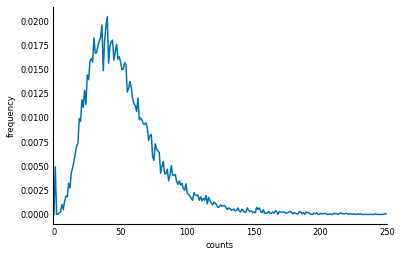

In [12]:
def integer_histogram(counts, normed=True, xlim=[], ylim=[],
                      *args, **kwargs):
    hist = np.bincount(counts)
    if normed:
        hist = hist / np.sum(hist)
    fig, ax = plt.subplots()
    ax.plot(np.arange(hist.size), hist, *args, **kwargs)
    ax.set_xlabel('counts')
    ax.set_ylabel('frequency')
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)

counts_arr = np.fromiter(counts.values(), dtype=int, count=len(counts))
integer_histogram(counts_arr, xlim=(-1, 250))

<!-- caption text="Histogram of k-mer counts" -->

Notice the nice distribution of k-mer frequencies, along with a big bump of k-mers (at the left of the plot) that appear only once.
Such low frequency k-mers are likely to be errors.

But, with the code above, we are actually doing a bit too much work.
A lot of the functionality we wrote in for loops and yields is actually *stream manipulation*: transforming a stream of data into a different kind of data, and accumulating it at the end.
Toolz has a lot of stream manipulation primitives that make it easy to write the above in just one function call; and, once you know the names of the transforming functions, it also becomes easier to visualize what is happening to your data stream at each point.

For example, the *sliding window* function is exactly what we need to make k-mers:

In [13]:
print(tz.sliding_window.__doc__)

 A sequence of overlapping subsequences

    >>> list(sliding_window(2, [1, 2, 3, 4]))
    [(1, 2), (2, 3), (3, 4)]

    This function creates a sliding window suitable for transformations like
    sliding means / smoothing

    >>> mean = lambda seq: float(sum(seq)) / len(seq)
    >>> list(map(mean, sliding_window(2, [1, 2, 3, 4])))
    [1.5, 2.5, 3.5]
    


Additionally, the *frequencies* function counts the appearance of individual items in a data stream.
Together with pipe, we can now count k-mers in a single function call:

In [14]:
from toolz import curried as c

k = 7
counts = tz.pipe('data/sample.fasta', open,
                 c.filter(is_sequence),
                 c.map(str.rstrip),
                 c.map(c.sliding_window(k)),
                 tz.concat, c.map(''.join),
                 tz.frequencies)

But, just a minute: what are all those `c.function` calls from `toolz.curried`?

## Currying: the spice of streaming

Earlier, we briefly used a *curried* version of the `map` function, which
applies a given function to each element in a sequence. Now that we've mixed a
few more curried calls in there, it's time share with you what it means!
Currying is not named after the spice blend (though it does spice up your code).
It is named for Haskell Curry, the mathematician who invented the concept.
Haskell Curry is also the namesake of the Haskell programming language — in which
*all* functions are curried!

"Currying" means *partially* evaluating a function and returning another, "smaller" function.
Normally in Python if you don't give a function all of its required arguments then it will throw a fit.
In contrast, a curried function can just take *some* of those arguments.
If the curried function doesn't get enough arguments, it returns a new function that takes the leftover arguments.
Once that second function is called with the remaining arguments, it can perform the original task.
Another word for currying is partial evaluation.
In functional programming, currying is a way to produce a function that can wait for the rest of the arguments to show up later.

So, while the function call `map(np.log, numbers_list)` applies the `np.log`
function to all of the numbers in `numbers_list` (returning a sequence of the
logged numbers), the call `toolz.curried.map(np.log)` returns a *function* that
takes in a sequence of numbers and returns a sequence of logged numbers.

It turns out that having a function that already knows about some of the arguments is perfect for streaming!
We've seen a hint of how powerful currying and pipes can be together in the
above code snippet.

But currying can be a bit of a mind-bend when you first start, so we'll try it with some simple examples to demonstrate how it works.
Let's start by writing a simple, non-curried function:

In [15]:
def add(a, b):
    return a + b

add(2, 5)

7

Now we write a similar function which we curry manually:

In [16]:
def add_curried(a, b=None):
    if b is None:
        # second argument not given, so make a function and return it
        def add_partial(b):
            return add(a, b)
        return add_partial
    else:
        # Both values were given, so we can just return a value
        return add(a, b)

Now let's try out a curried function to make sure it does what we expect.

In [17]:
add_curried(2, 5)

7

Okay, it acts like a normal function when given both variables.
Now let's leave out the second variable.

In [18]:
add_curried(2)

<function __main__.add_curried.<locals>.add_partial(b)>

As we expected, it returned a function.
Now let's use that function:

In [19]:
add2 = add_curried(2)
add2(5)

7

Now, that worked, but `add_curried` was a hard function to read.
Future us will probably have trouble remembering how we wrote that code.
Luckily, Toolz has the, well, tools to help us out.

In [20]:
import toolz as tz

@tz.curry  # Use curry as a decorator
def add(x, y):
    return x + y

add_partial = add(2)
add_partial(5)

7

To summarize what we did, `add` is now a curried function, so it can take one of the arguments and returns another function, `add_partial`, which “remembers” that argument.

In fact, all of the Toolz functions are also available as curried functions in the `toolz.curried` namespace.
Toolz also includes curried version of some handy higher order Python functions like `map`, `filter` and `reduce`.
We will import the `curried` namespace as `c` so our code doesn't get too cluttered.
So for example the curried version of `map` will be `c.map`.
Note, that the curried functions (e.g. `c.map`) are different from the `@curry` decorator, which is used to create a curried function.

In [21]:
from toolz import curried as c
c.map

<class 'map'>

As a reminder, `map` is a built-in function.
From the [docs](https://docs.python.org/3.4/library/functions.html#map):

> map(function, iterable, ...)
> Return an iterator that applies function to every item of iterable, yielding the results.

A curried version of `map` is particularly handy when working in a Toolz pipe.
You can just pass a function to `c.map` and then stream in the iterator later using `tz.pipe`.
Take another look at our function for reading in the genome to see how this works in practice.

In [22]:
def genome(file_pattern):
    """Stream a genome, letter by letter, from a list of FASTA filenames."""
    return tz.pipe(file_pattern, glob, sorted,  # Filenames
                   c.map(open),  # lines
                   # concatenate lines from all files:
                   tz.concat,
                   # drop header from each sequence
                   c.filter(is_sequence),
                   # concatenate characters from all lines
                   tz.concat,
                   # discard newlines and 'N'
                   c.filter(is_nucleotide))

## Back to counting k-mers

Okay, so now we've got our heads around curried, let's get back to our k-mer counting code.
Here's that code again that used those curried functions:

In [23]:
from toolz import curried as c

k = 7
counts = tz.pipe('data/sample.fasta', open,
                 c.filter(is_sequence),
                 c.map(str.rstrip),
                 c.map(c.sliding_window(k)),
                 tz.concat, c.map(''.join),
                 tz.frequencies)

We can now observe the frequency of different k-mers:

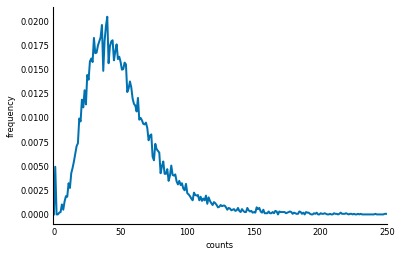

In [24]:
counts = np.fromiter(counts.values(), dtype=int, count=len(counts))
integer_histogram(counts, xlim=(-1, 250), lw=2)

<!-- caption text="Histogram of k-mer counts" -->

> **Tips for working with streams {.callout}**
>  - Convert "list of list" to "long list" with `tz.concat`
>  - Don’t get caught out:
>     * Iterators get consumed.
So if you make a generator object and do some processing on it, and then a later step fails, you need to re-create the generator.
The original is already gone.
>     * Iterators are lazy. You need to force evaluation sometimes.
>  - When you have lots of functions in a pipe, it’s sometimes hard to figure out where things go wrong.
     Take a small stream and add functions to your pipe one by one from the first/leftmost until you find the broken one.
     You can also insert `map(do(print))` (`map` and `do` are from
     `toolz.curried`) at any point in a stream to print each element while it
     streams through.

<!-- exercise begin -->

**Exercise:**
The scikit-learn library has an IncrementalPCA class, which allows you to run
principal components analysis on a dataset without loading the full dataset
into memory.
But you need to chunk your data yourself, which makes the code a bit awkward to
use.
Make a function that can take a stream of data samples and perform PCA.
Then, use the function to compute the PCA of the `iris` machine learning
dataset, which is in `data/iris.csv`. (You can also access it from the
`datasets` module of scikit-learn, using `datasets.load_iris()`.) Optionally,
you can color the points with the species number, found in
`data/iris-target.csv`.

*Hint:* The `IncrementalPCA` class is in `sklearn.decomposition`, and
requires a *batch size* greater than 1 to train the model. Look at the
`toolz.curried.partition` function for how to create a stream of batches from a
stream of data points.

<!-- solution begin -->

**Solution:**
First, we write the function to train the model. The function should take in a
stream of samples and output a PCA model, which can *transform* new samples by
projecting them from the original n-dimensional space to the principal
component space.

In [25]:
import toolz as tz
from toolz import curried as c
from sklearn import decomposition
from sklearn import datasets
import numpy as np

def streaming_pca(samples, n_components=2, batch_size=100):
    ipca = decomposition.IncrementalPCA(n_components=n_components,
                                        batch_size=batch_size)
    tz.pipe(samples,  # iterator of 1D arrays
            c.partition(batch_size),  # iterator of tuples
            c.map(np.array),  # iterator of 2D arrays
            c.map(ipca.partial_fit),  # partial_fit on each
            tz.last)  # Suck the stream of data through the pipeline
    return ipca

Now, we can use this function to *train* (or *fit*) a PCA model:

In [26]:
reshape = tz.curry(np.reshape)

def array_from_txt(line, sep=',', dtype=np.float):
    return np.array(line.rstrip().split(sep), dtype=dtype)

with open('data/iris.csv') as fin:
    pca_obj = tz.pipe(fin, c.map(array_from_txt), streaming_pca)

Finally, we can stream our original samples through the `transform` function of
our model. We stack them together to obtain a `n_samples` by `n_components`
matrix of data:

In [27]:
with open('data/iris.csv') as fin:
    components = tz.pipe(fin,
                         c.map(array_from_txt),
                         c.map(reshape(newshape=(1, -1))),
                         c.map(pca_obj.transform),
                         np.vstack)

print(components.shape)

(150, 2)


/Users/squiresrb/anaconda3/lib/python3.7/site-packages/toolz/functoolz.py:552: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  data = func(data)


We can now plot the components:

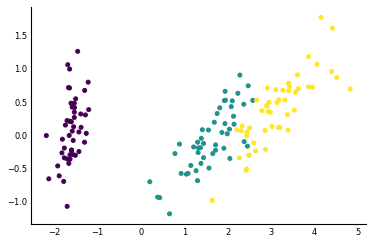

In [28]:
iris_types = np.loadtxt('data/iris-target.csv')
plt.scatter(*components.T, c=iris_types, cmap='viridis');

<!-- caption text="Principal components of iris dataset computed with streaming
PCA" -->

You can verify that this gives (approximately) the same result as a standard
PCA:

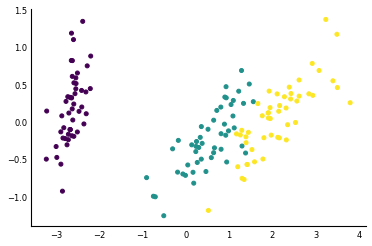

In [29]:
iris = np.loadtxt('data/iris.csv', delimiter=',')
components2 = decomposition.PCA(n_components=2).fit_transform(iris)
plt.scatter(*components2.T, c=iris_types, cmap='viridis');

<!-- caption text="Principal components of iris dataset computed with normal
PCA" -->

The difference, of course, is that streaming PCA can scale to extremely large
datasets.

<!-- solution end -->

<!-- exercise end -->

## Markov model from a full genome

Back to our original code example.
What is a Markov model, and why is it useful?

In general, a Markov model assumes that the probability of the system moving to a given state, is only dependent on the state that it was in just previously.
For example if it is sunny right now, there is a high probability that it will be sunny tomorrow.
The fact that it was raining yesterday is irrelevant.
In this theory, all the information required to predict the future is encoded in the current state of things.
The past is irrelevant.
This assumption is useful for simplifying otherwise intractable problems, and
often gives good results.
Markov models are behind much of the signal processing in mobile phone and
satellite communications, for example.

In the context of genomics, as we will see, different functional regions of a
genome have different *transition probabilities* between similar states.
Observing these in a new genome, we can predict something about the function of
those regions. Going back to the weather analogy, the probability of going from
a sunny day to a rainy day is very different depending on whether you are in
Los Angeles or London. Therefore, if I give you a string of (sunny, sunny,
sunny, rainy, sunny, ...) days, you can predict whether it came from Los
Angeles or London, assuming you have a previously trained model.

In this chapter, we'll cover just the model building, for now.

- You can download the *Drosophila melanogaster* (fruit fly) genome file dm6.fa.gz from
http://hgdownload.cse.ucsc.edu/goldenPath/dm6/bigZips/.
You will need to unzip it using: `gzip -d dm6.fa.gz`

In the genome data, genetic sequence, which consists of the letters A, C, G,
and T, is encoded as belonging to *repetitive elements*, a specific class of
DNA, by whether it is in lower case (repetitive) or upper case
(non-repetitive). We can use this information when we build the Markov model.

We want to encode the Markov model as a NumPy array, so we will make
dictionaries to index from letters to indices in [0, 7] (`LDICT` for "letters
dictionary"), and from pairs of letters to 2D indices in ([0, 7], [0, 7])
(`PDICT` or "pairs dictionary"):

In [30]:
import itertools as it

LDICT = dict(zip('ACGTacgt', range(8)))
PDICT = {(a, b): (LDICT[a], LDICT[b])
         for a, b in it.product(LDICT, LDICT)}

We also want to filter out non-sequence data: the sequence names, which are in
lines starting with `>`, and unknown sequence, which is labeled as `N`, so we
will make functions to filter on:

In [31]:
def is_sequence(line):
    return not line.startswith('>')

def is_nucleotide(letter):
    return letter in LDICT  # ignore 'N'

Finally, whenever we get a new nucleotide pair, say, ('A', 'T'), we want to
increment our Markov model (our NumPy matrix) at the corresponding position. We
make a curried function to do so:

In [32]:
import toolz as tz

@tz.curry
def increment_model(model, index):
    model[index] += 1

We can now combine these elements to stream a genome into our NumPy matrix.
Note that, if `seq` below is a stream, we never need to store the whole genome,
or even a big chunk of the genome, in memory!

In [33]:
from toolz import curried as c

def markov(seq):
    """Get a 1st-order Markov model from a sequence of nucleotides."""
    model = np.zeros((8, 8))
    tz.last(tz.pipe(seq,
                    c.sliding_window(2),        # each successive tuple
                    c.map(PDICT.__getitem__),   # location in matrix of tuple
                    c.map(increment_model(model))))  # increment matrix
    # convert counts to transition probability matrix
    model /= np.sum(model, axis=1)[:, np.newaxis]
    return model

Now we simply need to produce that genome stream, and make our Markov model:

In [34]:
from glob import glob

def genome(file_pattern):
    """Stream a genome, letter by letter, from a list of FASTA filenames."""
    return tz.pipe(file_pattern, glob, sorted,  # Filenames
                   c.map(open),  # lines
                   # concatenate lines from all files:
                   tz.concat,
                   # drop header from each sequence
                   c.filter(is_sequence),
                   # concatenate characters from all lines
                   tz.concat,
                   # discard newlines and 'N'
                   c.filter(is_nucleotide))

Let's try it out on the Drosophila (fruit fly) genome:

In [35]:
# Download dm6.fa.gz from ftp://hgdownload.cse.ucsc.edu/goldenPath/dm6/bigZips/
# Unzip before using: gzip -d dm6.fa.gz
dm = 'data/dm6.fa'
model = tz.pipe(dm, genome, c.take(10**7), markov)
# we use `take` to just run on the first 10 million bases, to speed things up.
# the take step can just be removed if you have ~5-10 mins to wait.

/Users/squiresrb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


Let's look at the resulting matrix:

In [36]:
print('    ', '      '.join('ACGTacgt'), '\n')
print(model)

     A      C      G      T      a      c      g      t 

[[  nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan]
 [0.    0.    0.    0.    0.667 0.333 0.    0.   ]
 [0.    0.    0.    0.    0.75  0.25  0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.   ]
 [0.    0.    0.    0.    0.    0.25  0.5   0.25 ]]


It's probably clearer to look at the result as an image:

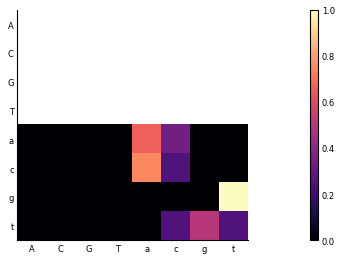

In [37]:
def plot_model(model, labels, figure=None):
    fig = figure or plt.figure()
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    im = ax.imshow(model, cmap='magma');
    axcolor = fig.add_axes([0.91, 0.1, 0.02, 0.8])
    plt.colorbar(im, cax=axcolor)
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_ticks(range(8))
        axis.set_ticks_position('none')
        axis.set_ticklabels(labels)
    return ax

plot_model(model, labels='ACGTacgt');

<!-- caption text="Transition probability matrix for genetic sequence in the
*Drosophila melanogaster* genome" -->

Notice how the C-A and G-C transitions are different between the repeat and
non-repeat parts of the genome. This information can be used to classify
previously unseen DNA sequence.

<!-- exercise begin -->

**Exercise:** add a step to the start of the pipe to unzip the data so you don't
have to keep a decompressed version on your hard drive. The Drosophila genome,
for example, takes less than a third of the space on disk when compressed with
gzip. And yes, unzipping can be streamed, too!

*Hint:* The `gzip` package, part of Python's standard library, allows you
to open `.gz` files as if they were normal files.

<!-- solution begin -->

**Solution:** We can replace `open` in the original `genome` code with a
curried version of `gzip.open`. The default mode of `gzip`'s `open` function is
`rb` (**r**ead **b**ytes), instead of `rt` for Python's built-in `open`
(**r**ead **t**ext), so we have to provide it.

In [38]:
import gzip

gzopen = tz.curry(gzip.open)


def genome_gz(file_pattern):
    """Stream a genome, letter by letter, from a list of FASTA filenames."""
    return tz.pipe(file_pattern, glob, sorted,  # Filenames
                   c.map(gzopen(mode='rt')),  # lines
                   # concatenate lines from all files:
                   tz.concat,
                   # drop header from each sequence
                   c.filter(is_sequence),
                   # concatenate characters from all lines
                   tz.concat,
                   # discard newlines and 'N'
                   c.filter(is_nucleotide))

You can try this out with the compressed drosophila genome file:

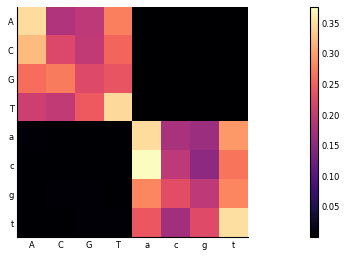

In [39]:
dm = 'data/dm6.fa.gz'
model = tz.pipe(dm, genome_gz, c.take(10**7), markov)
plot_model(model, labels='ACGTacgt')

If you want to have a single `genome` function, you could write a custom `open`
function that decides from filename or from trying and failing whether a file
is a gzip file.

Similarly, if you have a `.tar.gz` full of FASTA files, you can use Python's
`tarfile` module instead of `glob` to read each file individually. The only
caveat is that you will have to use the `bytes.decode` function to decode each
line, as `tarfile` returns them as bytes, not as text.

<!-- solution end -->

<!-- exercise end -->

We hope to have shown you at least a hint that streaming in Python can be easy
when you use a few abstractions, like the ones Toolz provides.

Streaming can make you more productive, because big data takes linearly longer
than small data. In batch analysis, big data can take forever to run, because
the operating system has to keep transferring data from RAM to the hard disk
and back. Or, Python might refuse altogether and simply show a `MemoryError`!
This means that, for many analyses, you don’t need a bigger machine to analyse
bigger datasets. And, if your tests pass on small data, they’ll pass on big
data, too!

Our take home message from this chapter is this: when writing an algorithm, or
analysis, think about whether you can do it streaming. If you can, just do it
from the beginning. Your future self will thank you.
Doing it later is harder, and results in things like this:

![TODOs in history. Comic by Manu Cornet, http://www.bonkersworld.net/all-engineers-are-the-same/, used with permission.](http://bonkersworld.net/img/2012.08.15_all_engineers_are_the_same.png)